In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from __future__ import division, print_function, absolute_import
from tf_utils import load_features_with_deltas_stacking, random_mini_batches

train_data, test_data, train_labels, test_labels = load_features_with_deltas_stacking()
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
#Seeding
seed = 3

# Network Parameters
input_h = train_data.shape[1] #Height
input_w = train_data.shape[2] #Width
num_classes = 2

X = tf.placeholder(tf.float32, [None, input_h, input_w])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32)

In [3]:
# Model
def sound_net(x, weights, biases, dropout):
    # Input Layer
    x = tf.reshape(x, shape=[-1, input_h, input_w, 1])

    # Convolutional Layer #1
    #input shape [batch, input_h, input_w, 1]
    #output shape [batch, input_h, input_w, 80]   
    conv1 = tf.nn.conv2d(x, weights['wc1'], padding="SAME", strides=[1,1,1,1])
    conv1 = tf.nn.bias_add(conv1, biases['bc1'])
    conv1 = tf.nn.relu(conv1)

    # Pooling Layer #1
    # Input Tensor Shape: [batch_size, input_h, input_w, 80]
    # Output Tensor Shape: [batch_size, input_h/2, input_w/2, 80]
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    
    pool1 = tf.nn.dropout(pool1,dropout)
    
    # Convolutional Layer #2
    #input shape [batch_size, input_h/2, input_w/2, 80]
    #output shape [batch_size, input_h/2, input_w/2, 80]
    conv2 = tf.nn.conv2d(pool1, weights['wc2'], padding="SAME", strides=[1,1,1,1])
    conv2 = tf.nn.bias_add(conv2, biases['bc2'])
    conv2 = tf.nn.relu(conv2)
    
    # Pooling Layer #2
    # Input Tensor Shape: [batch_size, input_h/2, input_w/2, 80]
    # Output Tensor Shape: [batch_size, input_h/16 input_w/14, 80]
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 8, 7, 1], strides=[1, 8, 7, 1], padding='SAME')    

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    dense1 = tf.reshape(pool2, [-1, weights['wd1'].get_shape().as_list()[0]])
    dense1 = tf.add(tf.matmul(dense1, weights['wd1']), biases['bd1'])
    dense1 = tf.nn.relu(dense1)
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1,dropout)
   
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    dense2 = tf.reshape(dense1, [-1, weights['wd2'].get_shape().as_list()[0]])
    dense2 = tf.add(tf.matmul(dense2, weights['wd2']), biases['bd2'])
    dense2 = tf.nn.relu(dense2)
    # Apply Dropout
    dense2=tf.nn.dropout(dense2,dropout)
   
    # Output, class prediction
    out = tf.add(tf.matmul(dense2, weights['out']), biases['out'])
    return out

In [4]:
# Store weights and biases
weights = {
    # 57x6 conv
    'wc1': tf.Variable(tf.random_normal([57, 6, 1, 80])),
    # 1x3 conv
    'wc2': tf.Variable(tf.random_normal([1, 3, 80, 80])),
    # fully connected, (input_h/16)*(input_w/14)*80 inputs (after maxpool), 1024 outputs
    # if our input is (128, 28) this will be 8*2*80
    'wd1': tf.Variable(tf.random_normal([int(input_h/16)*int(input_w/14)*80, 1024])),
    # fully connected, 1014 inputs (after maxpool), 1024 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 1024])),
    # 1024 inputs, 2 outputs
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([80])),
    'bc2': tf.Variable(tf.random_normal([80])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# build model
logits = sound_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize
init = tf.global_variables_initializer()

In [5]:
def run_model(num_epochs, train_data, train_labels, test_data, test_labels, minibatch_size, 
              seed, learn_rate, dropout):
    costs = []
    accuracies = []
    
    with tf.Session(graph=g) as sess:
                    
        sess.run(init)        
        #Print some info about the model executed.
        print('Training of the network with:')
        print('learning rate: ' + str(learn_rate) + ', dropout: ' + str(dropout) + '\n')                
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            epoch_accuracies = []
            seed = seed + 1
            epoch_start_time = time.time()
            minibatches = random_mini_batches(train_data, train_labels, minibatch_size, seed)

            for minibatch in minibatches:
                (batch_x, batch_y) = minibatch
                #convert to one_hot for labels
                batch_y = tf.one_hot(batch_y, num_classes)
                batch_y = sess.run(batch_y)
                batch_y = batch_y.reshape((batch_y.shape[0], num_classes))

                sess.run(train_op, feed_dict={X: batch_x, 
                                              Y: batch_y, 
                                              keep_prob: (1 - dropout), 
                                              learning_rate: learn_rate})
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                     Y: batch_y,
                                                                     keep_prob: (1 - dropout),
                                                                     learning_rate: learn_rate})
                epoch_cost += loss
                epoch_accuracies.append(acc)
            
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - epoch_start_time
            
            #After running all minibatches    
            epoch_accuracy = np.mean(epoch_accuracies)            
            if epoch % 10 == 0:
                print("Epoch " + str(epoch) + ", Loss= " + \
                      "{:.4f}".format(loss) + ", Accuracy= " + \
                      "{:.3f}".format(epoch_accuracy))
                print(per_epoch_ptime)
            if epoch % 5 == 0:
                costs.append(epoch_cost)
                accuracies.append(epoch_accuracy)

        #Plot loss over time
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title('learning rate: ' + str(learn_rate) + ', dropout: ' + str(dropout))
        plt.show()   

        #Plot accuracy over time
        plt.plot(np.squeeze(accuracies))
        plt.ylabel('accuracy (%)')
        plt.xlabel('iterations (per tens)')
        plt.title('learning rate: ' + str(learn_rate) + ', dropout: ' + str(dropout))
        plt.show()           

        # Test accuracy
        test_labels = tf.one_hot(test_labels, num_classes)
        test_labels = sess.run(test_labels)     
        
        print("Test Accuracy:", \
            sess.run(accuracy, feed_dict={X: test_data,
                                          Y: test_labels,
                                          keep_prob: 1.0}))

Training of the network with:
learning rate: 0.1, dropout: 0.1

Epoch 0, Loss= 459805.5312, Accuracy= 0.584
12.706498861312866
Epoch 10, Loss= 3370.3862, Accuracy= 0.824
9.574724197387695
Epoch 20, Loss= 930.1547, Accuracy= 0.872
10.92724871635437
Epoch 30, Loss= 33.0579, Accuracy= 0.880
11.350658655166626
Epoch 40, Loss= 0.2876, Accuracy= 0.840
12.928589344024658
Epoch 50, Loss= 38.3451, Accuracy= 0.725
16.01091766357422
Epoch 60, Loss= 84.2168, Accuracy= 0.713
15.325806617736816
Epoch 70, Loss= 92.1120, Accuracy= 0.715
16.42267918586731
Epoch 80, Loss= 0.5697, Accuracy= 0.733
17.625221014022827
Epoch 90, Loss= 54.3195, Accuracy= 0.702
21.207151651382446


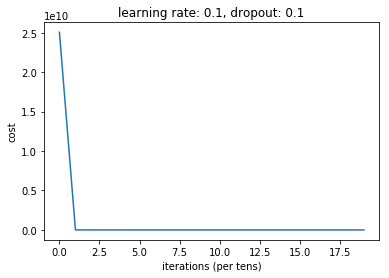

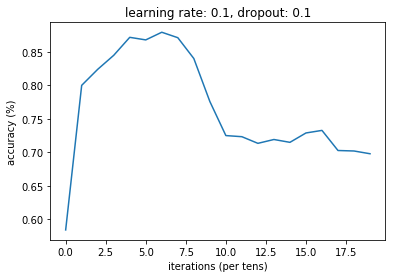

Test Accuracy: 0.7093596
----------------------------------------------------



In [6]:
run_model(num_epochs=100, train_data=train_data, train_labels=train_labels, test_data=test_data, 
          test_labels=test_labels, minibatch_size=64, learn_rate=0.1, seed=seed, dropout=0.1)

In [10]:
tf.reset_default_graph()